In [19]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import datetime
from pandas.tseries.offsets import BDay


In [64]:
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

In [60]:
class ichimoku():
    
    def __init__(self, instrument, source, started, end):
        self.df=data.DataReader(instrument, source, start, end)
        self._data = None
        self.instrument = instrument
        self._rangeselector = None
        self.cloud_frame = pd.DataFrame()
        self.efficiency_frame = None

        #Defining elements of ichimoku indicator
        period9_high = self.df['High'].rolling(window=9).max()
        period9_low = self.df['Low'].rolling(window=9).min()
        tenkan_series =  (period9_high + period9_low) / 2
        self.df['Tenkan-sen'] = tenkan_series
        
        period26_high = self.df['High'].rolling(window=26).max()
        period26_low =  self.df['Low'].rolling(window=26).min()       
        kijun_series = (period26_high + period26_low) / 2
        self.df['Kijun-sen'] = kijun_series
        
        cloud = pd.DataFrame()
        cloud['Senkou-span_1'] = (tenkan_series + kijun_series) / 2


        period52_high = self.df['High'].rolling(window=52).max()
        period52_low = self.df['Low'].rolling(window=52).min()
        
        cloud['Senkou-span_2'] = ((period52_high + period52_low) / 2)
        cloud.index = cloud.index + BDay(26)
        
        self.df['Chikou-span'] = self.df['Close'].shift(-26)
        
        self.df = self.df.join(cloud, how='right')

        

        self.df['helper_column'] = np.where(self.df.index > datetime.datetime.today(), 1, 'NaN')
        self.df = self.df.apply(pd.to_numeric, errors='coerce')
        self.df.dropna(thresh=3, inplace=True)
        
        self.df.drop(labels='helper_column', axis=1, inplace=True)
        self.efficiency_frame = self.df
    
    @property
    def data(self):
        if self._data is None:
            #candlestick chart data for our first series to plot
            #also is the candlestick element itself
            self._data = [go.Candlestick(
                    x = self.df.index,
                    open = self.df.Open,
                    high = self.df.High,
                    low = self.df.Low,
                    close = self.df.Close,
                    name = self.instrument,
                    yaxis='y2'
            )]
        return self._data

    @property
    def rangeselector(self):
        #populate the rangeselector object with necessary settings
        if self._rangeselector == None:
            rangeselector = {   
            'visible' : True,
            'x' : 0, 'y' : 0.9,
            'bgcolor' : 'rgba(148, 152, 161, 0.4)',
            'font' : {'size' : 13},
            'buttons' : [
                {'count' : 1, 'label' : 'reset', 'step' : 'all'},
                {'count' : 1, 'label' : '1yr', 'step' : 'year', 'stepmode' : 'backward'},
                {'count' : 3, 'label' : '3 mo', 'step' : 'month', 'stepmode' : 'backward'},
                {'count' : 1, 'label' : '1 mo', 'step' : 'month', 'stepmode' : 'backward'},
                {'step' : 'all'},
            ]
            }
        return self._rangeselector


    def fig(self):
        #main chart fig consists of data and layout settings 
        fig = go.Figure()
        # Assign various seeting and choices - background colour, range selector etc
        fig['layout']['plot_bgcolor'] = 'rgb(44, 48, 56)'
        fig['layout']['xaxis'] = {'rangeselector' : {'visible' : True}}
        fig['layout']['yaxis'] = {
                        'domain' : [0, 0.2], 
                        'showticklabels' : False 
                                }
        fig['layout']['yaxis2'] = {'domain' : [0.2, 0.8]}
        fig['layout']['margin'] = {
                        't' : 40,
                        'b' : 40,
                        'r' : 40,
                        'l' : 40
                                    }      
        fig['layout']['xaxis']['rangeselector'] = self.rangeselector

        #append the ichimoku elements to the plot
        #there are some funny breaks in all lines except for cloud, so we have to exclude rows with NA's from the middle of the frame 
        # we want to keep the tail of the frame is full of NA's because cloud is shifted forward
         #append the ichimoku elements to the plot
        self.data.append(go.Scatter(
                        x = self.df['Tenkan-sen'].index, y = self.df['Tenkan-sen'],
                        type = 'scatter',
                        line = {'width' : 1},
                        marker = {'color' : '#de7b12'},
                        yaxis = 'y2',
                        name = 'Tenkan-sen'
        ))
        self.data.append(go.Scatter(
                        x = self.df['Kijun-sen'].index, y = self.df['Kijun-sen'],
                        type = 'scatter', mode = 'lines',
                        line = {'width' : 1},
                        marker = {'color' : '#1245de'},
                        yaxis = 'y2',
                        name = 'Kijun-sen'
        ))                
        self.data.append(go.Scatter(
                        x = self.df['Senkou-span_2'].index, y = self.df['Senkou-span_2'],
                        type = 'scatter', mode = 'lines',
                        line = {'width' : 1}, 
                        marker = {'color' : '#FF3341'},
                        yaxis = 'y2',
                        name = 'Senkou-span 2'
        ))        
        self.data.append(go.Scatter(
                        x = self.df['Senkou-span_1'].index, y = self.df['Senkou-span_1'],
                        type = 'scatter', mode = 'lines',
                        line = {'width' : 1}, fill = 'tonexty',
                        marker = {'color' : '#228B22'},
                        yaxis = 'y2',
                        name = 'Senkou-span 1'
        ))                  
        self.data.append(go.Scatter(
                        x = self.df['Chikou-span'].index, y = self.df['Chikou-span'],
                        type = 'scatter', mode = 'lines',
                        line = {'width' : 1},
                        marker = {'color' : '#046e08'},
                        yaxis = 'y2',
                        name = 'Chikou-span-span 1'
        ))        
        fig.add_traces(self.data)
        return fig

    
    def chart(self):
        self.fig().show()



    def _dropnans(self):
        self.efficiency_frame.dropna(inplace=True) 



    def _cloud_check(self):
        #now we will do two checks:
        #first - to check if the price is above cloud, we will set value as 1 if so,
        #second- to check if the price is below cloud, we will set value as -1 if so,
        #we can't do it in a single check because price can be in cloud, then it'll be 0
        self.efficiency_frame['above_cloud'] = 0
        
        self.efficiency_frame['above_cloud'] = np.where(
            (self.efficiency_frame['Close'] > self.efficiency_frame['Senkou-span_1'])
            &
            (self.efficiency_frame['Close'] > self.efficiency_frame['Senkou-span_2']),
            1, self.efficiency_frame['above_cloud']
                                        )

        self.efficiency_frame['above_cloud'] = np.where(
            (self.efficiency_frame['Close'] < self.efficiency_frame['Senkou-span_1'])
            &
            (self.efficiency_frame['Close'] < self.efficiency_frame['Senkou-span_2']),
            -1, self.efficiency_frame['above_cloud']
                                        )

        self.efficiency_frame['green_cloud'] = np.where(
            (self.efficiency_frame['Senkou-span_1'] > self.efficiency_frame['Senkou-span_2']),
            1, -1)


    def _price_check(self):
        #original code from the blog, we will try .shift(-1) instead of .shift(1) in next version of the code
        #gold_cross is substitute of "tenkan_kiju_cross" from original code,
        #  i named it like that to follow the Hosoda's nomenclature
        #gold cross is kiju
        self.efficiency_frame['gold_cross'] = np.NaN
        self.efficiency_frame['gold_cross'] = np.where(
            (self.efficiency_frame['Tenkan-sen'].shift(1) <= self.efficiency_frame['Kijun-sen'].shift(1)) 
            & 
            (self.efficiency_frame['Tenkan-sen'] > self.efficiency_frame['Kijun-sen']),
            1, self.efficiency_frame['gold_cross']
                                        )
        self.efficiency_frame['gold_cross'] = np.where(
            (self.efficiency_frame['Tenkan-sen'].shift(1) >= self.efficiency_frame['Kijun-sen'].shift(1))
            &
            (self.efficiency_frame['Tenkan-sen'] < self.efficiency_frame['Kijun-sen']),
            -1, self.efficiency_frame['gold_cross'] #criteria of closing position
                                        )
        self.efficiency_frame['price_tenkan_cross'] = np.NaN
        self.efficiency_frame['price_tenkan_cross'] = np.where(
            (self.efficiency_frame['Open'].shift(1) <= self.efficiency_frame['Tenkan-sen'].shift(1))
            &
            (self.efficiency_frame['Close'] > self.efficiency_frame['Tenkan-sen']),
            1, self.efficiency_frame['price_tenkan_cross']
                                                )
        self.efficiency_frame['price_tenkan_cross'] = np.where(
            (self.efficiency_frame['Open'].shift(1) >= self.efficiency_frame['Tenkan-sen'].shift(1))
            &
            (self.efficiency_frame['Close'] < self.efficiency_frame['Tenkan-sen']),
            -1, self.efficiency_frame['price_tenkan_cross']
                                                )

    
    def _strategy_logic(self):
        #creation of actual buy and sell entry signals
        self.efficiency_frame['buy'] = np.NaN  #np.NAN only as a placeholder.
        #placeholder will not change unless first two criteria
        #and at least one of the last 2 criterias are met
        self.efficiency_frame['buy'] = np.where(
            (self.efficiency_frame['above_cloud'].shift(1) == 1) & (self.efficiency_frame['green_cloud'].shift(1) == 1)
            & 
            ((self.efficiency_frame['gold_cross'].shift(1) == 1) | (self.efficiency_frame['price_tenkan_cross'].shift(1) == 1))
            , 1, self.efficiency_frame['buy']
            )

        self.efficiency_frame['buy'] = np.where(self.efficiency_frame['gold_cross'].shift(1) == -1, 0, self.efficiency_frame['buy'])
        self.efficiency_frame['buy'].ffill(inplace=True)

        self.efficiency_frame['sell'] = np.NaN
        self.efficiency_frame['sell'] = np.where(
            (self.efficiency_frame['above_cloud'].shift(1) == -1) & (self.efficiency_frame['green_cloud'].shift(1) == -1)
            & 
            ((self.efficiency_frame['gold_cross'].shift(1) == -1) | (self.efficiency_frame['price_tenkan_cross'].shift(1) == -1)),
            -1, self.efficiency_frame['sell'])
        self.efficiency_frame['sell'] = np.where(self.efficiency_frame['gold_cross'].shift(1) == 1, 0, self.efficiency_frame['sell'])
        self.efficiency_frame['sell'].ffill(inplace=True)
        self.efficiency_frame['position'] = self.efficiency_frame['buy'] + self.efficiency_frame['sell']

    def efficiency_evaluation(self):
        self._dropnans()
        self._cloud_check()
        self._price_check()
        self._strategy_logic()
        #below code checks the returns of stock itself and the strategy
        self.efficiency_frame['stock_returns'] = np.log(self.efficiency_frame['Open']) - np.log(self.efficiency_frame['Open'].shift(1))
        self.efficiency_frame['strategy_returns'] = self.efficiency_frame['stock_returns'] * self.efficiency_frame['position']
        self.efficiency_frame[['stock_returns','strategy_returns']].cumsum().plot(figsize=(15,8))

In [65]:

ford = ichimoku('F', 'yahoo', start, end)


In [69]:
ford.chart()

ford.df

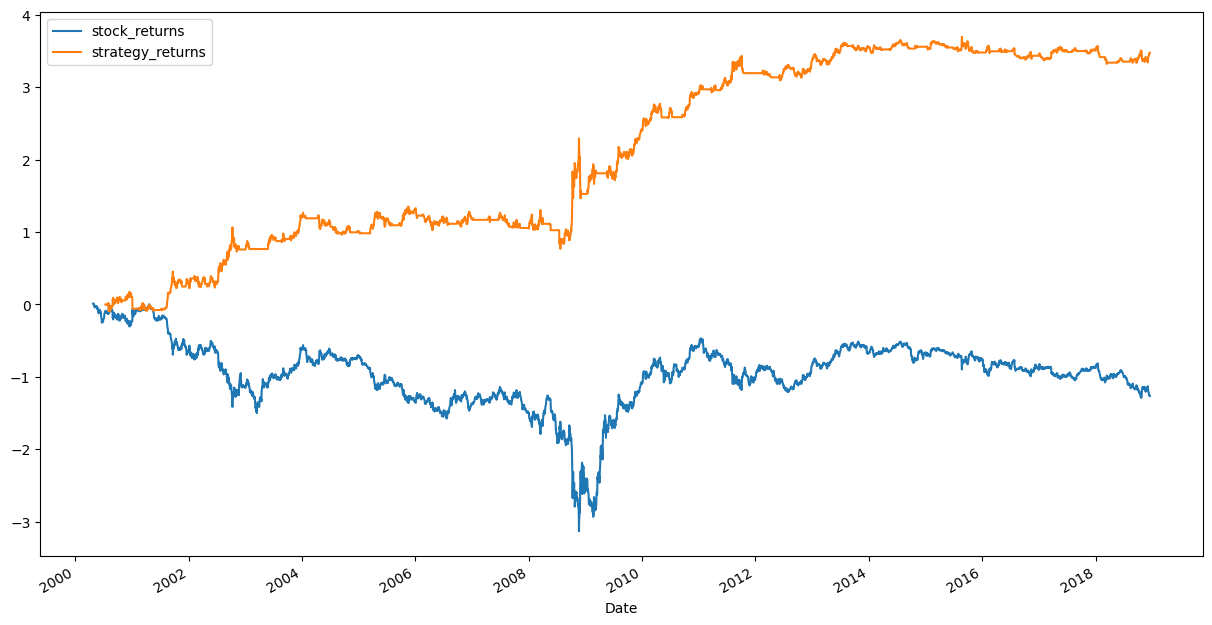

In [66]:
ford.efficiency_evaluation()

In [67]:
netflix = ford = ichimoku('NFLX', 'yahoo', start, end)

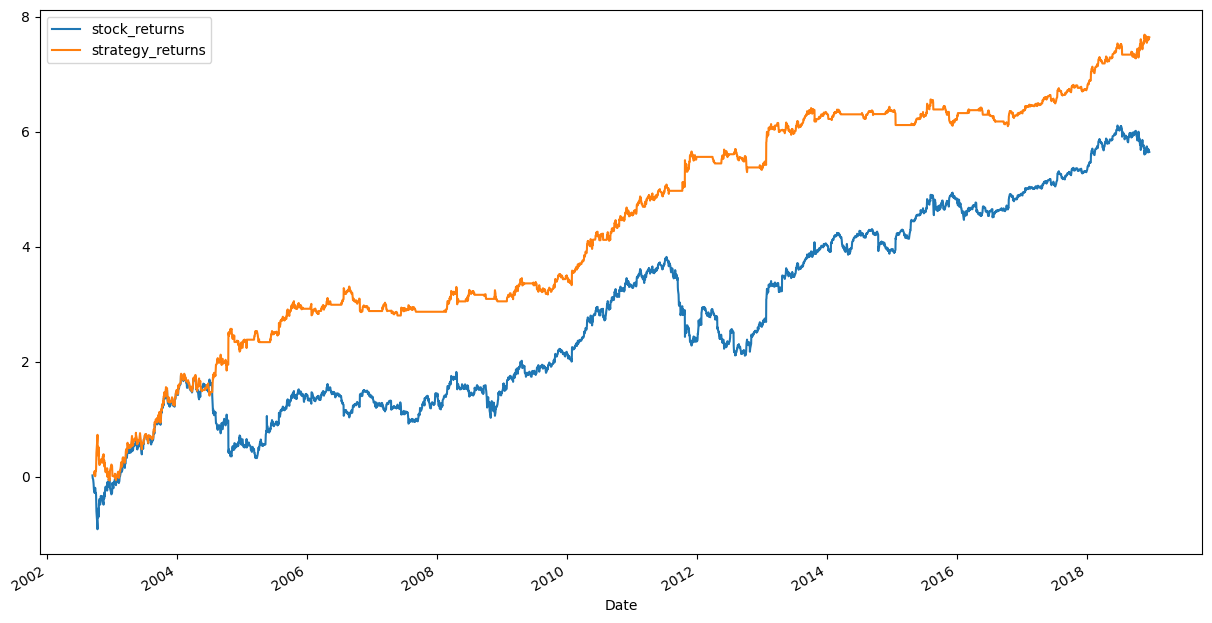

In [68]:
netflix.efficiency_evaluation()